# Análisis de Trayectorias: La Dinámica de Preparación de la Fase 2

## Hipótesis
> **"La Fase 2 (N2) no es un estado estático, sino dinámico. Su representación vectorial (embedding) cambia gradualmente para 'preparar' la transición hacia la siguiente fase (REM o Sueño Profundo)."**

## Justificación de Parámetros
Basado en el análisis previo de las leyes de potencia y la distribución del **Primer Ciclo de Sueño**, hemos determinado que la duración promedio de un bloque consolidado de N2 es de aproximadamente **6 épocas** (3 minutos).

Por lo tanto, utilizaremos **n-gramas de tamaño $N=6$** para entrenar nuestro modelo Word2Vec. Esto nos permite capturar la ventana temporal en la que hipotetizamos que ocurre la preparación fisiológica.

## El Experimento del "Deslizador"
Simularemos una transición gradual modificando sintéticamente la composición del n-grama paso a paso:
1.  **Estado Puro:** **[2, 2, 2, 2, 2, 2]**
2.  **Transición:** **[2, 2, 2, 2, 2, Destino]** $\to$ ... $\to$ **[Destino, Destino, Destino, Destino, Destino, Destino]**
3.  **Medición:** Calcularemos la **Distancia Coseno** entre el vector del estado puro y cada paso de la transición.

**Objetivo:** Observar si la trayectoria hacia **REM** se separa de la trayectoria hacia **SWS** (Sueño Profundo) *antes* de que el n-grama sea mayoritariamente de la nueva fase.

In [69]:
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import plotly.graph_objects as go
import plotly.express as px
from scipy.spatial.distance import cosine

# Configuración
RUTA_DATOS = Path("../Datos")  # Ruta relativa a la carpeta Notebooks
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Mapa de fases unificado (consistente con fase2_s2_dinamica.ipynb)
ETIQUETAS_FASES = {
    0: "Vigilia (W)",
    1: "S1",
    2: "S2",
    3: "S3/S4",
    4: "REM",
    5: "Movimiento/SC"
}

def agrupar_fase(valor):
    """Mapea cualquier fase cruda al alfabeto reducido (igual que en fase2_s2_dinamica)."""
    return {4: 3, 5: 4, 6: 5, 7: 5}.get(valor, valor)


def remapear_secuencia(secuencia):
    """Aplica `agrupar_fase` a cada época para unificar símbolos antes del conteo."""
    return [agrupar_fase(valor) for valor in secuencia]

print("Librerías cargadas y configuración lista.")

Librerías cargadas y configuración lista.


In [70]:
def cargar_y_procesar_datos(ruta_datos, aplicar_agrupacion=True):
    """
    Carga datos y genera 6-gramas.
    
    CORRECCIÓN METODOLÓGICA: Por defecto, aplica agrupación para mantener consistencia
    con el análisis de trayectorias hacia SWS (S3/S4 agrupado). Si aplicar_agrupacion=False,
    genera n-gramas con datos crudos (separando S3 de S4).
    """
    archivos = sorted([f.name for f in ruta_datos.iterdir() 
                      if f.is_file() and f.name.startswith("Scoring_") and f.name.endswith("_2")])
    if not archivos:
        raise FileNotFoundError(f"No se encontraron archivos Scoring_*_2 en {ruta_datos}")
    
    todos_los_ngramas = []
    
    print(f"Procesando {len(archivos)} pacientes...")
    
    for archivo in archivos:
        try:
            # Cargar hipnograma
            ruta_archivo = ruta_datos / archivo
            df = pd.read_csv(ruta_archivo, sep=r'\s+', header=None, 
                           names=["epoca", "scor_clean", "scor_quasi"])
            # Usar la columna scor_clean (índice 1)
            raw_seq = df["scor_clean"].astype(int).tolist() 
            
            # Aplicar agrupación solo si se solicita (por defecto True para mantener consistencia)
            if aplicar_agrupacion:
                seq_procesada = remapear_secuencia(raw_seq)
            else:
                seq_procesada = raw_seq  # Mantener datos crudos
            
            # Generar 6-gramas (Ventana deslizante de 6)
            # Convertimos a string "2-2-2..." para que sea un token único
            N = 6
            for i in range(len(seq_procesada) - N + 1):
                ventana = seq_procesada[i : i+N]
                token = "-".join(map(str, ventana))
                todos_los_ngramas.append(token)
                
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")
            
    return todos_los_ngramas

# Ejecutar carga
corpus_ngramas = cargar_y_procesar_datos(RUTA_DATOS)
print(f"Total de 6-gramas generados: {len(corpus_ngramas)}")
print(f"Ejemplo: {corpus_ngramas[:5]}")

Procesando 10 pacientes...
Total de 6-gramas generados: 9451
Ejemplo: ['5-5-5-5-5-5', '5-5-5-5-5-5', '5-5-5-5-5-5', '5-5-5-5-5-5', '5-5-5-5-5-5']


In [71]:
# 1. Construir Vocabulario
frecuencias = Counter(corpus_ngramas)
# Filtramos tokens muy raros para limpiar el espacio (opcional, min_freq=2)
min_freq = 1
vocabulario = sorted([w for w, c in frecuencias.items() if c >= min_freq])
word2idx = {w: i for i, w in enumerate(vocabulario)}
idx2word = {i: w for w, i in word2idx.items()}

print(f"Tamaño del vocabulario (tokens únicos): {len(vocabulario)}")

# 2. Dataset Skip-Gram
class SleepNgramDataset(Dataset):
    def __init__(self, corpus_tokens, word2idx, window_size=1):
        self.pairs = []
        # Convertir todo el corpus a índices
        indices = [word2idx[t] for t in corpus_tokens if t in word2idx]
        
        # Generar pares (centro, contexto)
        # Como nuestros tokens YA son n-gramas temporales, el contexto es el n-grama vecino
        for i, target in enumerate(indices):
            for w in range(1, window_size + 1):
                if i - w >= 0:
                    self.pairs.append((target, indices[i - w]))
                if i + w < len(indices):
                    self.pairs.append((target, indices[i + w]))
                    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.pairs[idx][0]), torch.tensor(self.pairs[idx][1])

# Crear dataset y dataloader
dataset = SleepNgramDataset(corpus_ngramas, word2idx, window_size=1) # Ventana 1 porque el token ya es de 6
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

print(f"Total de pares de entrenamiento: {len(dataset)}")

Tamaño del vocabulario (tokens únicos): 833
Total de pares de entrenamiento: 18900


In [72]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = self.linear(embeds)
        return out

    def get_embedding(self, word_idx):
        return self.embeddings(word_idx).detach().numpy()

# Configuración del Entrenamiento
EMBEDDING_DIM = 32  # Dimensión del vector
EPOCHS = 30
LEARNING_RATE = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Word2Vec(len(vocabulario), EMBEDDING_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Loop de Entrenamiento
print(f"Iniciando entrenamiento en {device}...")
loss_history = []

for epoch in range(EPOCHS):
    total_loss = 0
    for center, context in dataloader:
        center, context = center.to(device), context.to(device)
        
        optimizer.zero_grad()
        outputs = model(center)
        loss = criterion(outputs, context)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

print("¡Entrenamiento completado!")

Iniciando entrenamiento en cpu...
Epoch 5/30, Loss: 0.9919
Epoch 10/30, Loss: 0.7694
Epoch 15/30, Loss: 0.7402
Epoch 20/30, Loss: 0.7269
Epoch 25/30, Loss: 0.7245
Epoch 30/30, Loss: 0.7214
¡Entrenamiento completado!


In [73]:
def generar_trayectoria(fase_inicio, fase_destino, pasos=6):
    """
    Genera la lista de tokens que representan la transición paso a paso.
    Ejemplo: 2-2-2 -> 2-2-4 -> 2-4-4...
    """
    tokens = []
    # Paso 0: Todo inicio (ej. 2-2-2-2-2-2)
    tokens.append("-".join([str(fase_inicio)] * pasos))
    
    # Pasos intermedios
    actual = [fase_inicio] * pasos
    for i in range(pasos):
        # Desplazamos: entra uno del destino por la derecha
        actual.pop(0)
        actual.append(fase_destino)
        tokens.append("-".join(map(str, actual)))
        
    return tokens

# Generar las dos trayectorias de interés
trayectoria_rem = generar_trayectoria(2, 4, pasos=6) # Hacia REM
trayectoria_sws = generar_trayectoria(2, 3, pasos=6) # Hacia SWS

print("Trayectoria a REM:", trayectoria_rem)
print("Trayectoria a SWS:", trayectoria_sws)

Trayectoria a REM: ['2-2-2-2-2-2', '2-2-2-2-2-4', '2-2-2-2-4-4', '2-2-2-4-4-4', '2-2-4-4-4-4', '2-4-4-4-4-4', '4-4-4-4-4-4']
Trayectoria a SWS: ['2-2-2-2-2-2', '2-2-2-2-2-3', '2-2-2-2-3-3', '2-2-2-3-3-3', '2-2-3-3-3-3', '2-3-3-3-3-3', '3-3-3-3-3-3']


In [74]:
from plotly.subplots import make_subplots

def obtener_vector(token, model, word2idx):
    if token in word2idx:
        idx = torch.tensor([word2idx[token]]).to(device)
        return model.embeddings(idx).cpu().detach().numpy()[0]
    else:
        return None 

def calcular_distancias_y_separacion(tray_a, tray_b, vector_origen, model, word2idx):
    """
    Calcula la distancia al origen para cada trayectoria,
    Y TAMBIÉN la distancia entre los puntos correspondientes de ambas (separación).
    """
    d_a_origen = []
    d_b_origen = []
    d_entre_ellos = [] # Distancia entre A[i] y B[i]
    labels = []
    
    for ta, tb in zip(tray_a, tray_b):
        va = obtener_vector(ta, model, word2idx)
        vb = obtener_vector(tb, model, word2idx)
        
        # Distancias al origen
        da = cosine(vector_origen, va) if va is not None else None
        db = cosine(vector_origen, vb) if vb is not None else None
        
        # Distancia entre ellos (REM vs SWS en el mismo paso)
        if va is not None and vb is not None:
            d_ab = cosine(va, vb)
        else:
            d_ab = None
            
        d_a_origen.append(da)
        d_b_origen.append(db)
        d_entre_ellos.append(d_ab)
        labels.append(f"Paso {len(labels)}")
            
    return d_a_origen, d_b_origen, d_entre_ellos

# 1. Vector Base y Cálculos
token_base = "2-2-2-2-2-2"
vector_base = obtener_vector(token_base, model, word2idx)

if vector_base is None:
    print(f"Error: Token base {token_base} no encontrado.")
else:
    # Calcular métricas
    dist_rem, dist_sws, dist_entre = calcular_distancias_y_separacion(
        trayectoria_rem, trayectoria_sws, vector_base, model, word2idx
    )
    
    # Filtrar Nones para graficar
    x_axis = list(range(len(dist_rem)))
    
    # --- GRAFICAR CON SUBPLOTS ---
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=("Distancia desde el Origen (N2 Puro)", "Distancia ENTRE trayectorias (REM vs SWS)"),
        row_heights=[0.7, 0.3]
    )

    # 1. TRAYECTORIAS (Panel Superior)
    # Hacia REM
    fig.add_trace(go.Scatter(
        x=x_axis, y=dist_rem,
        mode='lines+markers+text',
        name='Hacia REM',
        line=dict(color='#AB63FA', width=3),
        marker=dict(size=10, color='#AB63FA'),
        text=[f"{d:.2f}" if d else "" for d in dist_rem],
        textposition="top left",
        hovertemplate="Token: %{text}<br>Dist al origen: %{y:.4f}"
    ), row=1, col=1)

    # Hacia SWS
    fig.add_trace(go.Scatter(
        x=x_axis, y=dist_sws,
        mode='lines+markers+text',
        name='Hacia SWS',
        line=dict(color='#00CC96', width=3),
        marker=dict(size=10, color='#00CC96'),
        text=[f"{d:.2f}" if d else "" for d in dist_sws],
        textposition="bottom right",
        hovertemplate="Token: %{text}<br>Dist al origen: %{y:.4f}"
    ), row=1, col=1)

    # 2. SEPARACIÓN ENTRE ELLOS (Panel Inferior - Gráfico de Barras)
    fig.add_trace(go.Bar(
        x=x_axis, y=dist_entre,
        name='Separación (Distancia REM-SWS)',
        marker_color='#FFA15A',
        text=[f"{d:.3f}" if d else "" for d in dist_entre],
        textposition='auto',
        hovertemplate="<b>Separación:</b> %{y:.4f}<extra></extra>"
    ), row=2, col=1)

    # Estilos Globales
    fig.update_layout(
        title="<b>Dinámica de Preparación y Separación de Fases</b> (N=6)",
        template="plotly_dark",
        paper_bgcolor="black",
        plot_bgcolor="black",
        height=700,
        hovermode="x unified",
        legend=dict(x=0.01, y=0.99, bgcolor="rgba(0,0,0,0)")
    )
    
    # Ejes
    fig.update_yaxes(title_text="Dist. desde Inicio", row=1, col=1)
    fig.update_yaxes(title_text="Dist. REM <-> SWS", row=2, col=1)
    fig.update_xaxes(title_text="Progreso de la Transición", row=2, col=1)

    # Anotación de inicio
    fig.add_annotation(
        x=0, y=0, text="Origen", showarrow=True, arrowhead=2,
        font=dict(color="white"), row=1, col=1
    )

    fig.show()
    
    # Imprimir tabla de distancias entre pares
    print("\nDetalle de Distancias ENTRE trayectorias (Separación):")
    print(f"{'Paso':<5} | {'Token REM':<15} | {'Token SWS':<15} | {'Distancia entre ellos'}")
    print("-" * 65)
    for i, (tr, ts, d) in enumerate(zip(trayectoria_rem, trayectoria_sws, dist_entre)):
        val_d = f"{d:.4f}" if d is not None else "N/A"
        print(f"{i:<5} | {tr:<15} | {ts:<15} | {val_d}")


Detalle de Distancias ENTRE trayectorias (Separación):
Paso  | Token REM       | Token SWS       | Distancia entre ellos
-----------------------------------------------------------------
0     | 2-2-2-2-2-2     | 2-2-2-2-2-2     | 0.0000
1     | 2-2-2-2-2-4     | 2-2-2-2-2-3     | 0.7953
2     | 2-2-2-2-4-4     | 2-2-2-2-3-3     | 0.8067
3     | 2-2-2-4-4-4     | 2-2-2-3-3-3     | 0.7808
4     | 2-2-4-4-4-4     | 2-2-3-3-3-3     | 1.1110
5     | 2-4-4-4-4-4     | 2-3-3-3-3-3     | 0.7860
6     | 4-4-4-4-4-4     | 3-3-3-3-3-3     | 0.9038


## Experimento de Control: Datos Revueltos (Shuffling)

Para validar que la separación observada no es artefactual, entrenamos un modelo "falso" con los mismos datos pero con el orden temporal destruido mediante **np.random.shuffle()**. Si la estructura es real, las trayectorias del modelo falso deberían estar superpuestas (sin separación), mientras que las del modelo real muestran la preparación dinámica.

In [75]:
def cargar_y_procesar_datos_revueltos(ruta_datos, seed_shuffle=None, aplicar_agrupacion=True):
    """
    Carga los datos raw de todos los pacientes, los revuelve y genera 6-gramas.
    Esto destruye el orden temporal para crear un modelo de control.
    
    CORRECCIÓN METODOLÓGICA: Por defecto, aplica agrupación para mantener consistencia
    con el modelo real. Debe usar el mismo valor de aplicar_agrupacion que cargar_y_procesar_datos.
    """
    if seed_shuffle is not None:
        np.random.seed(seed_shuffle)
    
    archivos = sorted([f.name for f in ruta_datos.iterdir() 
                      if f.is_file() and f.name.startswith("Scoring_") and f.name.endswith("_2")])
    if not archivos:
        raise FileNotFoundError(f"No se encontraron archivos Scoring_*_2 en {ruta_datos}")
    
    todas_las_secuencias = []
    
    print(f"Procesando {len(archivos)} pacientes (datos revueltos)...")
    
    for archivo in archivos:
        try:
            ruta_archivo = ruta_datos / archivo
            df = pd.read_csv(ruta_archivo, sep=r'\s+', header=None, 
                           names=["epoca", "scor_clean", "scor_quasi"])
            raw_seq = df["scor_clean"].astype(int).tolist()
            
            # Revuelve la secuencia (destruye el orden temporal)
            seq_revuelta = raw_seq.copy()
            np.random.shuffle(seq_revuelta)
            
            # Aplicar agrupación solo si se solicita (debe coincidir con el modelo real)
            if aplicar_agrupacion:
                seq_procesada = remapear_secuencia(seq_revuelta)
            else:
                seq_procesada = seq_revuelta  # Mantener datos crudos
            
            todas_las_secuencias.append(seq_procesada)
                
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")
    
    # Generar 6-gramas de todas las secuencias revueltas
    todos_los_ngramas = []
    N = 6
    for seq_procesada in todas_las_secuencias:
        for i in range(len(seq_procesada) - N + 1):
            ventana = seq_procesada[i : i+N]
            token = "-".join(map(str, ventana))
            todos_los_ngramas.append(token)
    
    return todos_los_ngramas

# Generar corpus revuelto
corpus_ngramas_falso = cargar_y_procesar_datos_revueltos(RUTA_DATOS, seed_shuffle=123)
print(f"Total de 6-gramas generados (revueltos): {len(corpus_ngramas_falso)}")
print(f"Ejemplo: {corpus_ngramas_falso[:5]}")

Procesando 10 pacientes (datos revueltos)...
Total de 6-gramas generados (revueltos): 9451
Ejemplo: ['4-2-4-4-4-4', '2-4-4-4-4-2', '4-4-4-4-2-5', '4-4-4-2-5-4', '4-4-2-5-4-2']


In [76]:
# Construir vocabulario del modelo falso (mismo proceso que el real)
frecuencias_falso = Counter(corpus_ngramas_falso)
vocabulario_falso = sorted([w for w, c in frecuencias_falso.items() if c >= min_freq])
word2idx_falso = {w: i for i, w in enumerate(vocabulario_falso)}
idx2word_falso = {i: w for w, i in word2idx_falso.items()}

print(f"Tamaño del vocabulario falso (tokens únicos): {len(vocabulario_falso)}")

# Crear dataset y dataloader para el modelo falso
dataset_falso = SleepNgramDataset(corpus_ngramas_falso, word2idx_falso, window_size=1)
dataloader_falso = DataLoader(dataset_falso, batch_size=512, shuffle=True)

print(f"Total de pares de entrenamiento (falso): {len(dataset_falso)}")

Tamaño del vocabulario falso (tokens únicos): 3984
Total de pares de entrenamiento (falso): 18900


In [77]:
# Entrenar modelo falso (mismos parámetros que el real)
model_falso = Word2Vec(len(vocabulario_falso), EMBEDDING_DIM).to(device)
optimizer_falso = torch.optim.Adam(model_falso.parameters(), lr=LEARNING_RATE)
criterion_falso = nn.CrossEntropyLoss()

print(f"Iniciando entrenamiento del modelo falso en {device}...")
loss_history_falso = []

for epoch in range(EPOCHS):
    total_loss = 0
    for center, context in dataloader_falso:
        center, context = center.to(device), context.to(device)
        
        optimizer_falso.zero_grad()
        outputs = model_falso(center)
        loss = criterion_falso(outputs, context)
        loss.backward()
        optimizer_falso.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader_falso)
    loss_history_falso.append(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

print("¡Entrenamiento del modelo falso completado!")

Iniciando entrenamiento del modelo falso en cpu...


Epoch 5/30, Loss: 3.8385
Epoch 10/30, Loss: 2.1763
Epoch 15/30, Loss: 1.9084
Epoch 20/30, Loss: 1.8383
Epoch 25/30, Loss: 1.8069
Epoch 30/30, Loss: 1.7872
¡Entrenamiento del modelo falso completado!


In [78]:
# Calcular trayectorias del modelo falso
def obtener_vector_falso(token, model_falso, word2idx_falso):
    if token in word2idx_falso:
        idx = torch.tensor([word2idx_falso[token]]).to(device)
        return model_falso.embeddings(idx).cpu().detach().numpy()[0]
    else:
        return None

def calcular_distancias_trayectoria_falso(trayectoria, vector_origen, model_falso, word2idx_falso):
    """Calcula distancias para el modelo falso."""
    distancias = []
    tokens_validos = []
    for t in trayectoria:
        vec = obtener_vector_falso(t, model_falso, word2idx_falso)
        if vec is not None:
            d = cosine(vector_origen, vec)
            distancias.append(d)
            tokens_validos.append(t)
        else:
            distancias.append(None)
            tokens_validos.append(f"{t} (N/A)")
    return distancias, tokens_validos

# Vector base del modelo falso
vector_base_falso = obtener_vector_falso(token_base, model_falso, word2idx_falso)

if vector_base_falso is None:
    print(f"Advertencia: El token base {token_base} no está en el vocabulario falso.")
    dist_rem_falso = [None] * len(trayectoria_rem)
    dist_sws_falso = [None] * len(trayectoria_sws)
    labels_rem_falso = [f"{t} (N/A)" for t in trayectoria_rem]
    labels_sws_falso = [f"{t} (N/A)" for t in trayectoria_sws]
else:
    dist_rem_falso, labels_rem_falso = calcular_distancias_trayectoria_falso(
        trayectoria_rem, vector_base_falso, model_falso, word2idx_falso
    )
    dist_sws_falso, labels_sws_falso = calcular_distancias_trayectoria_falso(
        trayectoria_sws, vector_base_falso, model_falso, word2idx_falso
    )

print("Trayectorias del modelo falso calculadas.")

Trayectorias del modelo falso calculadas.


In [79]:
# Graficar comparación Real vs. Falso
fig = go.Figure()

# Filtrar valores None para el modelo real
indices_rem = [i for i, d in enumerate(dist_rem) if d is not None]
valores_rem = [d for d in dist_rem if d is not None]
labels_rem_filtrados = [labels_rem[i] for i in indices_rem]

indices_sws = [i for i, d in enumerate(dist_sws) if d is not None]
valores_sws = [d for d in dist_sws if d is not None]
labels_sws_filtrados = [labels_sws[i] for i in indices_sws]

# Filtrar valores None para el modelo falso
indices_rem_falso = [i for i, d in enumerate(dist_rem_falso) if d is not None]
valores_rem_falso = [d for d in dist_rem_falso if d is not None]
labels_rem_falso_filtrados = [labels_rem_falso[i] for i in indices_rem_falso]

indices_sws_falso = [i for i, d in enumerate(dist_sws_falso) if d is not None]
valores_sws_falso = [d for d in dist_sws_falso if d is not None]
labels_sws_falso_filtrados = [labels_sws_falso[i] for i in indices_sws_falso]

# Línea Real REM (sólida)
fig.add_trace(go.Scatter(
    x=indices_rem,
    y=valores_rem,
    mode='lines+markers',
    name='Real → REM',
    line=dict(color='#AB63FA', width=3),
    marker=dict(size=10, color='#AB63FA'),
    text=labels_rem_filtrados,
    hovertemplate="<b>Paso:</b> %{x}<br><b>Token:</b> %{text}<br><b>Distancia:</b> %{y:.4f}<extra></extra>"
))

# Línea Real SWS (sólida)
fig.add_trace(go.Scatter(
    x=indices_sws,
    y=valores_sws,
    mode='lines+markers',
    name='Real → SWS',
    line=dict(color='#00CC96', width=3),
    marker=dict(size=10, color='#00CC96'),
    text=labels_sws_filtrados,
    hovertemplate="<b>Paso:</b> %{x}<br><b>Token:</b> %{text}<br><b>Distancia:</b> %{y:.4f}<extra></extra>"
))

# Línea Falso REM (punteada)
fig.add_trace(go.Scatter(
    x=indices_rem_falso,
    y=valores_rem_falso,
    mode='lines+markers',
    name='Falso → REM',
    line=dict(color='#AB63FA', width=2, dash='dash'),
    marker=dict(size=8, color='#AB63FA'),
    opacity=0.7,
    text=labels_rem_falso_filtrados,
    hovertemplate="<b>Paso:</b> %{x}<br><b>Token:</b> %{text}<br><b>Distancia:</b> %{y:.4f}<extra></extra>"
))

# Línea Falso SWS (punteada)
fig.add_trace(go.Scatter(
    x=indices_sws_falso,
    y=valores_sws_falso,
    mode='lines+markers',
    name='Falso → SWS',
    line=dict(color='#00CC96', width=2, dash='dash'),
    marker=dict(size=8, color='#00CC96'),
    opacity=0.7,
    text=labels_sws_falso_filtrados,
    hovertemplate="<b>Paso:</b> %{x}<br><b>Token:</b> %{text}<br><b>Distancia:</b> %{y:.4f}<extra></extra>"
))

fig.update_layout(
    title="<b>Comparación Real vs. Falso:</b> Dinámica de Preparación (N=6)",
    xaxis_title="Progreso de la Transición (Cantidad de épocas destino)",
    yaxis_title="Distancia Coseno desde 'N2 Puro'",
    template="plotly_dark",
    paper_bgcolor="black",
    plot_bgcolor="black",
    height=600,
    hovermode="x unified",
    legend=dict(
        title="Trayectoria",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        font=dict(size=12)
    )
)

# Añadir anotación explicativa
if len(valores_rem) > 0:
    fig.add_annotation(
        x=0, 
        y=valores_rem[0] if valores_rem else 0, 
        text="Inicio (N2 Puro)", 
        showarrow=True, 
        arrowhead=2,
        arrowcolor="white",
        font=dict(color="white", size=10),
        bgcolor="rgba(0,0,0,0.7)",
        bordercolor="white"
    )

fig.show()

# Mostrar resumen de resultados
print("\n=== Resumen de Trayectorias ===")
print(f"\nModelo Real:")
print(f"  Trayectoria REM: {len(valores_rem)} puntos válidos de {len(dist_rem)} totales")
print(f"  Trayectoria SWS: {len(valores_sws)} puntos válidos de {len(dist_sws)} totales")
if valores_rem and valores_sws:
    print(f"  Distancia máxima REM: {max(valores_rem):.4f}")
    print(f"  Distancia máxima SWS: {max(valores_sws):.4f}")
    print(f"  Separación (diferencia): {abs(max(valores_rem) - max(valores_sws)):.4f}")

print(f"\nModelo Falso (Shuffled):")
print(f"  Trayectoria REM: {len(valores_rem_falso)} puntos válidos de {len(dist_rem_falso)} totales")
print(f"  Trayectoria SWS: {len(valores_sws_falso)} puntos válidos de {len(dist_sws_falso)} totales")
if valores_rem_falso and valores_sws_falso:
    print(f"  Distancia máxima REM: {max(valores_rem_falso):.4f}")
    print(f"  Distancia máxima SWS: {max(valores_sws_falso):.4f}")
    print(f"  Separación (diferencia): {abs(max(valores_rem_falso) - max(valores_sws_falso)):.4f}")
    
print("\n=== Interpretación ===")
print("Si la estructura es real, las líneas punteadas (Falso) deberían estar superpuestas,")
print("mientras que las líneas sólidas (Real) muestran la separación de preparación dinámica.")


=== Resumen de Trayectorias ===

Modelo Real:
  Trayectoria REM: 7 puntos válidos de 7 totales
  Trayectoria SWS: 7 puntos válidos de 7 totales
  Distancia máxima REM: 1.1029
  Distancia máxima SWS: 0.8229
  Separación (diferencia): 0.2800

Modelo Falso (Shuffled):
  Trayectoria REM: 6 puntos válidos de 7 totales
  Trayectoria SWS: 6 puntos válidos de 7 totales
  Distancia máxima REM: 1.2135
  Distancia máxima SWS: 1.1504
  Separación (diferencia): 0.0631

=== Interpretación ===
Si la estructura es real, las líneas punteadas (Falso) deberían estar superpuestas,
mientras que las líneas sólidas (Real) muestran la separación de preparación dinámica.


## Interpretación de Resultados

En este gráfico estamos observando **cuánto cambia la "identidad" vectorial** de la fase N2 conforme se contamina gradualmente con la fase destino.

1.  **Eje X:** Representa el tiempo avanzando hacia la transición. En 0 es N2 puro, en 6 es la fase destino pura.
2.  **Eje Y (Distancia):** Indica qué tan diferente es el estado actual respecto al estado de N2 estable.

**Lo que buscamos (La "Preparación"):**
* Si una línea sube **más rápido** que la otra (especialmente en los pasos 1, 2 o 3), significa que el modelo detecta un cambio de contexto **anticipado**.
* Por ejemplo, si la línea morada (REM) se dispara hacia arriba desde el paso 1, sugiere que **incluso una pequeña "pizca" de REM altera drásticamente la dinámica de N2**, señalando una preparación biológica distinta a la de SWS.

In [80]:
from collections import Counter
import pandas as pd
from pathlib import Path

# --- CONFIGURACIÓN (consistente con fase2_s2_dinamica) ---
RUTA_DATOS_AUDIT = Path("../Datos")

# Usar las mismas funciones de mapeo que en fase2_s2_dinamica
def agrupar_fase_audit(valor):
    """Mapea cualquier fase cruda al alfabeto reducido (igual que en fase2_s2_dinamica)."""
    return {4: 3, 5: 4, 6: 5, 7: 5}.get(valor, valor)


def remapear_secuencia_audit(secuencia):
    """Aplica `agrupar_fase` a cada época para unificar símbolos."""
    return [agrupar_fase_audit(valor) for valor in secuencia]


def procesar_auditoria():
    """Audita las frecuencias de las trayectorias sintéticas en los datos reales."""
    # Trayectorias sintéticas (consistente con el mapeo: 3=S3/S4, 4=REM)
    trayectoria_sws = ["2-2-2-2-2-2", "2-2-2-2-2-3", "2-2-2-2-3-3", "2-2-2-3-3-3", "2-2-3-3-3-3", "2-3-3-3-3-3", "3-3-3-3-3-3"]
    trayectoria_rem = ["2-2-2-2-2-2", "2-2-2-2-2-4", "2-2-2-2-4-4", "2-2-2-4-4-4", "2-2-4-4-4-4", "2-4-4-4-4-4", "4-4-4-4-4-4"]

    conteos = Counter()
    
    # Listar archivos
    archivos = sorted([f.name for f in RUTA_DATOS_AUDIT.iterdir() 
                      if f.is_file() and f.name.startswith("Scoring_") and f.name.endswith("_2")])
    
    if not archivos:
        print(f"ERROR: No se encontraron archivos Scoring_*_2 en {RUTA_DATOS_AUDIT}")
        return

    print(f"Auditando {len(archivos)} pacientes en {RUTA_DATOS_AUDIT}...")

    for archivo in archivos:
        try:
            # Cargar hipnograma (igual que en fase2_s2_dinamica)
            ruta_archivo = RUTA_DATOS_AUDIT / archivo
            df = pd.read_csv(ruta_archivo, sep=r'\s+', header=None, 
                           names=["epoca", "scor_clean", "scor_quasi"])
            raw_seq = df["scor_clean"].astype(int).tolist()
            
            # Unificar usando la misma lógica que fase2_s2_dinamica
            seq_unificada = remapear_secuencia_audit(raw_seq)
            
            # Generar 6-gramas
            for i in range(len(seq_unificada) - 6 + 1):
                ventana = seq_unificada[i : i+6]
                token = "-".join(map(str, ventana))
                conteos[token] += 1
                
        except Exception as e:
            print(f"Error en {archivo}: {e}")

    # Reporte
    print(f"\n{'N-grama':<15} | {'Frecuencia'}")
    print("-" * 30)
    
    print("--- Hacia SWS (3 = S3/S4) ---")
    for t in trayectoria_sws:
        print(f"{t:<15} | {conteos[t]:>6}")
        
    print("\n--- Hacia REM (4) ---")
    for t in trayectoria_rem:
        print(f"{t:<15} | {conteos[t]:>6}")

procesar_auditoria()

Auditando 10 pacientes en ../Datos...

N-grama         | Frecuencia
------------------------------
--- Hacia SWS (3 = S3/S4) ---
2-2-2-2-2-2     |   2714
2-2-2-2-2-3     |    104
2-2-2-2-3-3     |     38
2-2-2-3-3-3     |     27
2-2-3-3-3-3     |     34
2-3-3-3-3-3     |     55
3-3-3-3-3-3     |   1468

--- Hacia REM (4) ---
2-2-2-2-2-2     |   2714
2-2-2-2-2-4     |     35
2-2-2-2-4-4     |     32
2-2-2-4-4-4     |     35
2-2-4-4-4-4     |     41
2-4-4-4-4-4     |     59
4-4-4-4-4-4     |   1432


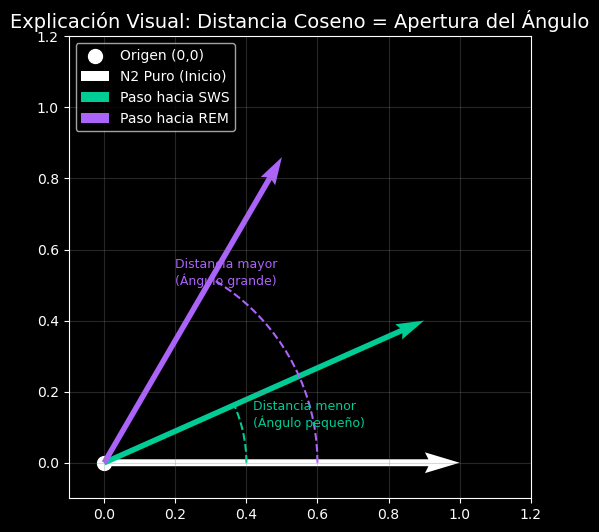

In [81]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cosine_concept():
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Origen
    ax.scatter(0, 0, color='white', s=100, label='Origen (0,0)')
    
    # Vectores simulados (simplificados a 2D para visualización)
    # N2 Puro (Base)
    v_base = np.array([1, 0]) 
    
    # Transición a SWS (Cambia poco a poco)
    v_sws = np.array([0.9, 0.4]) 
    
    # Transición a REM (Cambia drásticamente de dirección)
    v_rem = np.array([0.5, 0.86]) 
    
    # Plot vectors using quiver
    ax.quiver(0, 0, v_base[0], v_base[1], angles='xy', scale_units='xy', scale=1, color='white', label='N2 Puro (Inicio)', width=0.015)
    ax.quiver(0, 0, v_sws[0], v_sws[1], angles='xy', scale_units='xy', scale=1, color='#00CC96', label='Paso hacia SWS', width=0.012)
    ax.quiver(0, 0, v_rem[0], v_rem[1], angles='xy', scale_units='xy', scale=1, color='#AB63FA', label='Paso hacia REM', width=0.012)

    # Arcos para ángulos
    theta_sws = np.linspace(0, np.arctan2(v_sws[1], v_sws[0]), 20)
    x_arc_sws = 0.4 * np.cos(theta_sws)
    y_arc_sws = 0.4 * np.sin(theta_sws)
    ax.plot(x_arc_sws, y_arc_sws, color='#00CC96', linestyle='--')
    ax.text(0.42, 0.1, "Distancia menor\n(Ángulo pequeño)", color='#00CC96', fontsize=9)

    theta_rem = np.linspace(0, np.arctan2(v_rem[1], v_rem[0]), 20)
    x_arc_rem = 0.6 * np.cos(theta_rem)
    y_arc_rem = 0.6 * np.sin(theta_rem)
    ax.plot(x_arc_rem, y_arc_rem, color='#AB63FA', linestyle='--')
    ax.text(0.2, 0.5, "Distancia mayor\n(Ángulo grande)", color='#AB63FA', fontsize=9)

    # Configuración
    ax.set_xlim(-0.1, 1.2)
    ax.set_ylim(-0.1, 1.2)
    ax.set_aspect('equal')
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')
        
    ax.set_title('Explicación Visual: Distancia Coseno = Apertura del Ángulo', color='white', fontsize=14)
    ax.legend(facecolor='black', labelcolor='white', loc='upper left')
    ax.grid(True, color='gray', alpha=0.3)
    
    # Guardar
    plt.savefig('cosine_explanation.png')

plot_cosine_concept()